# Predicting Term Sheet Purchase

#### Model Buidling Steps

- 
- 
- 
- 
- 
- 
- 

#### References

- https://stackoverflow.com/questions/46062679/right-order-of-doing-feature-selection-pca-and-normalization

- https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb

- https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

- https://stats.stackexchange.com/questions/363548/use-of-smote-with-training-test-and-dev-sets

- https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

- https://ro-che.info/articles/2017-12-11-pca-explained-variance

- https://www.researchgate.net/deref/http%3A%2F%2Fwww.marcoaltini.com%2Fblog%2Fdealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

> Import analysis and visualization libraires

In [168]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

> Import dataset

- drop duration column (directly impacts the target varible and not good for modelling)

In [169]:
path= '../../datasets/main_data/bank-additional-full.csv'
full_bank = pd.read_csv(path, sep=';')

In [170]:
full_bank.shape

(41188, 21)

In [171]:
full_bank.drop('duration', axis=1, inplace=True)

In [172]:
full_bank.shape

(41188, 20)

> import project-defined modules

In [173]:
from plot import plot_univariate, plot_bivariate
from data import check_outliers, treat_outliers

> Import preprocessing libraries

In [174]:
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE, _random_over_sampler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, from_model, SelectKBest,chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest # outlier detection and re,oval
from collections import Counter

> Import estimator libraries

In [221]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

> Import libraries for measuring model perofrmance

In [176]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

> Import production libraries

In [229]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipe
import joblib

#### Data Preprocessing

In [178]:
full_bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [179]:
full_bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [180]:
full_bank.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

#### Outlier Detection and Treatment

> check for outliers

In [181]:
check_outliers(full_bank)

,age,campaign,pdays,previous,cons.conf.idx
0,56,1,999,0,-36.4
1,57,1,999,0,-36.4
2,37,1,999,0,-36.4
3,40,1,999,0,-36.4
4,56,1,999,0,-36.4
...,...,...,...,...,...
41183,73,1,999,0,-50.8
41184,46,1,999,0,-50.8
41185,56,2,999,0,-50.8
41186,44,1,999,0,-50.8


> treat outliers

In [182]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(full_bank.select_dtypes(exclude='object'))
# select all rows that are not outliers
mask = yhat != -1 
clean_df1 = full_bank[mask]
# summarize the shape of the updated training dataset
print(clean_df1.shape)

(37069, 20)


In [183]:
clean_df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40550,34,blue-collar,married,basic.9y,no,yes,no,cellular,aug,tue,2,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no
40551,44,admin.,single,high.school,no,yes,no,telephone,aug,tue,1,999,0,nonexistent,-1.7,94.027,-38.3,0.886,4991.6,no
40743,35,admin.,married,university.degree,no,yes,no,telephone,sep,wed,1,999,0,nonexistent,-1.1,94.199,-37.5,0.876,4963.6,no
40746,37,admin.,married,university.degree,no,no,yes,cellular,sep,thu,1,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,yes


#### Now let's check for class imbalance

Text(0.7, 30000, "Class Imbalance Count:\n\n{'no': 34194, 'yes': 2875}")

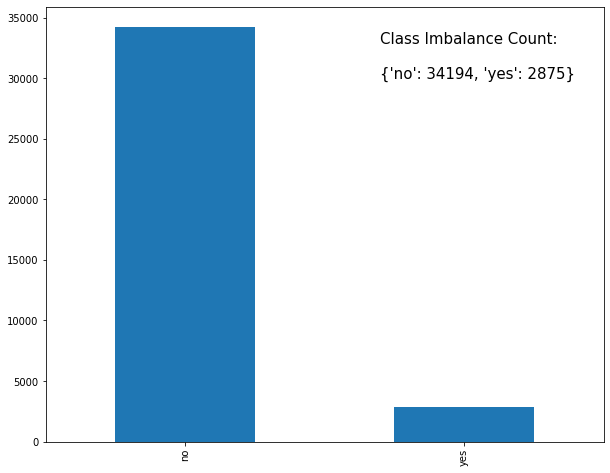

In [184]:
plt.subplots(figsize=(10,8))
clean_df1['y'].value_counts().plot(kind='bar')
plt.text(x=0.7, y=30000, s=f'Class Imbalance Count:\n\n{clean_df1.y.value_counts().to_dict()}', fontsize=15)

> We have a very high class imbalance

> This would be dealt with after splitting out data to train and test and applied only to train to avoid data leakage

#### split data

> Beofore further preprocessing, it is important we split the data into train and test set to avoid `data leakage`

In [185]:
features, target = clean_df1.drop('y', axis=1), pd.DataFrame(clean_df1['y'])

#### encode categorical variables

In [186]:
def encode (data):
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', )
    to_encode = data.select_dtypes(exclude='number')
    if data.shape[1] > 1:
        #ohe = MultiLabelBinarizer()
        data.drop(to_encode.columns.tolist(), axis=1, inplace = True)
        features_cat_encode = pd.DataFrame(ohe.fit_transform(to_encode))
        data = data.merge(features_cat_encode, left_index=True, right_index=True)
        #print(ohe.classes_) 
    else:
        data = pd.DataFrame(ohe.fit_transform(to_encode))
        print(ohe.categories_) 
    return data 

In [187]:
features = encode(features)
features

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,52
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37062,43,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
37063,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
37064,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
37065,32,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [188]:
target = encode(target)

[array(['no', 'yes'], dtype=object)]


In [189]:
target

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
37064,1.0,0.0
37065,1.0,0.0
37066,1.0,0.0
37067,0.0,1.0


> make shape equal

In [190]:
target=target.iloc[0:features.shape[0]]

In [191]:
target

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
36365,1.0,0.0
36366,1.0,0.0
36367,1.0,0.0
36368,1.0,0.0


> trim target varibles `purchase` to a single column of `yes`

In [192]:
target.drop(0, axis=1, inplace=True)

/home/patrick/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [193]:
target

,1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
36365,0.0
36366,0.0
36367,0.0
36368,0.0


In [194]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                               test_size=.10, random_state=1234)

In [195]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,52
20427,51,1,999,0,1.4,93.444,-36.1,4.966,5228.1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
22084,46,4,999,0,1.4,93.444,-36.1,4.964,5228.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1212,30,1,999,0,1.1,93.994,-36.4,4.855,5191.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12205,50,3,999,0,1.4,93.918,-42.7,4.956,5228.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31204,33,2,999,1,-1.8,92.893,-46.2,1.334,5099.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32920,57,2,999,0,-1.8,92.893,-46.2,1.299,5099.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
17231,58,7,999,0,1.4,93.918,-42.7,4.962,5228.1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
24199,40,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
34621,28,2,999,0,-1.8,92.893,-46.2,1.266,5099.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [196]:
y_train

,1
20182,0.0
21839,0.0
1212,0.0
12041,0.0
30693,0.0
...,...
32399,0.0
17048,0.0
23924,0.0
34086,0.0


#### Deal with class imbalance

In [197]:
y_train[1].value_counts()

0.0    30391
1.0     2342
Name: 1, dtype: int64

> Since we have an imbalance case of very high majority vs very low minority,

> a good decision would be to use the SMOTE technique of oversampling the minority to mathc the majority class

> However, accroding to some research, [example](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html), oversmapling before cross validation is a bad idea, as it leads to  high scores but overfitted model. Hence we would suspend sampling till when we are ready to apply cross validation on the train sets

> We now have a balanced class and can go on to further preprocess

#### Normalize X_train and X_test datasets

> I would be using the RobustScaler which is less prone to outliers

In [198]:
scaler = RobustScaler()
scaler

RobustScaler()

In [199]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [200]:
X_train_scaled

array([[ 0.92857143, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57142857,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57142857, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.14285714, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.71428571,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.28571429, -0.5       ,  0.        , ...,  1.        ,
        -1.        ,  0.        ]])

In [201]:
X_test_scaled

array([[-0.53333333, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33333333, -0.5       ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [ 1.46666667,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.2       ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.93333333, -0.5       ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [ 0.86666667, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [202]:
X_train_scaled.shape 

(32733, 62)

#### Dimensionality Reduction

> RIght now, our input variables are quite large, which has potential of affecting our prediciton

> To optimise the predictive features of our variables and save memory space on the model,

> we can reduce the number of features using PCA

First let's plot the number of components we need to get the most explained variance of our data

- Xtrain

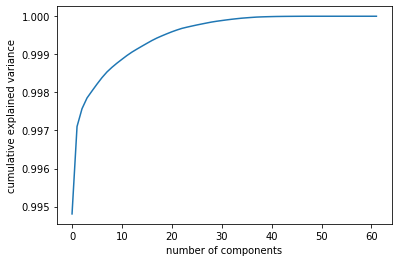

In [240]:
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');  

From the plot above, we can see that we need about 50 components to get an high explained variance

and no longer 62 features from the scaled X train set

In [236]:
# pca = PCA(50, random_state=0)  # project from 64 to 2 dimensions
# X_train_reduced = pca.fit_transform(X_train_scaled)
# X_test_reduced = pca.fit_transform(X_test_scaled)
# print(X_train_reduced.shape) 
# print(X_test_reduced.shape)

In [237]:
# cum_var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
# cum_var

<!-- > We can observe that as the number of components increases, ther is increased in the level of explanation

> And from 41 upward there is really no much difference

> First component expalains 44.1% of the dataset, first two, 52.6, first 5, 65.4% and so on...

> Think of this as diminishing marginal return on total variance explained

> Which means we need these many features to build a good model -->

<!-- #### We can plot this to see how it works...

# plt.subplots(figsize=(9,6))
# plt.ylabel('% Variance Explained')
# plt.xlabel('# of Features')
# plt.title('PCA Analysis')
# plt.ylim(44.1,100.5)
# plt.style.context('seaborn-whitegrid')
# text = f'Total explainable variance of all {cum_var.shape[0]} components is apprx:\n       \
# {round(np.sum(pca.explained_variance_ratio_)*100,4)}%'
# plt.text(x=10, y=70, s= text, fontsize=13)
# plt.plot(cum_var); -->

##### Before I move further let's test that PCA was a good decsion after all by fitting the PCA in a Logostic regression model usng stratified cross validation and comparing the score achived without using PCA

> All of this would be placed within a pipeline

In [235]:
pca = PCA(50)

smt = SMOTE(random_state=42)

log = LogisticRegression(max_iter=10000, tol=0.1)

imb_pipeline = ImbPipe([('smt', smt), ('pca', pca), ('log', log)])

#X_train, X_test, y_train, y_test = tts(X, y, random_state=42)

imb_pipeline.fit(X_train, y_train) 
y_hat = imb_pipeline.predict(X_test) 

print(classification_report(y_test, y_hat))

/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

         0.0       0.95      0.71      0.82      3386
         1.0       0.12      0.55      0.20       251

    accuracy                           0.70      3637
   macro avg       0.54      0.63      0.51      3637
weighted avg       0.90      0.70      0.77      3637



In [246]:
scv = StratifiedKFold()
#set pipeline parameters 
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'log__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(imb_pipeline,param_grid, n_jobs=-1, cv=scv)
search.fit(X_train, y_train)

/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                       ('pca', PCA(n_components=50)),
                                       ('log',
                                        LogisticRegression(max_iter=10000,
                                                           tol=0.1))]),
             n_jobs=-1,
             param_grid={'log__C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'pca__n_components': [5, 15, 30, 45, 64]})

Best parameter (CV score=0.730):
{'log__C': 0.0001, 'pca__n_components': 5}


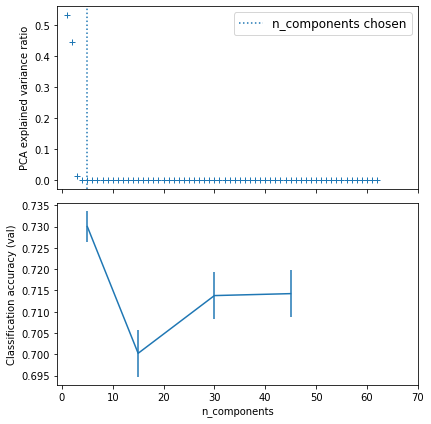

In [247]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

#### Perform feature selection on numerical features

> At first I will plot the feature importacne for all featurs then decide on the number to use depending on the number of features

In [226]:
features_num = features.select_dtypes(include='number')
features_num.shape

(36084, 62)

In [227]:
scaler = StandardScaler()

In [168]:
# define feature selection, 
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(features_num, target)

/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SelectKBest(k='all')

> PLot Feature Importance

Feature 0: 29.371084
Feature 1: 76.221529
Feature 2: 10.009152
Feature 3: 0.139565
Feature 4: 1312.651487
Feature 5: 583.512400
Feature 6: 155.743507
Feature 7: 1228.455657
Feature 8: 1397.298094


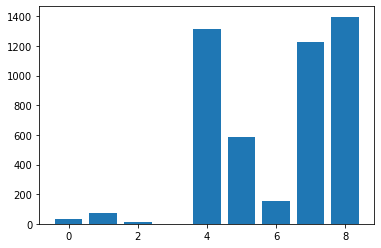

In [169]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [170]:
num_kbest = pd.DataFrame(fs.scores_, columns=['scores']).sort_values(
    ascending=False, by='scores').reset_index().rename(columns={'index':'features'})
num_kbest

,features,scores
0,8,1397.298094
1,4,1312.651487
2,7,1228.455657
3,5,583.512400
4,6,155.743507
5,1,76.221529
6,0,29.371084
7,2,10.009152
8,3,0.139565


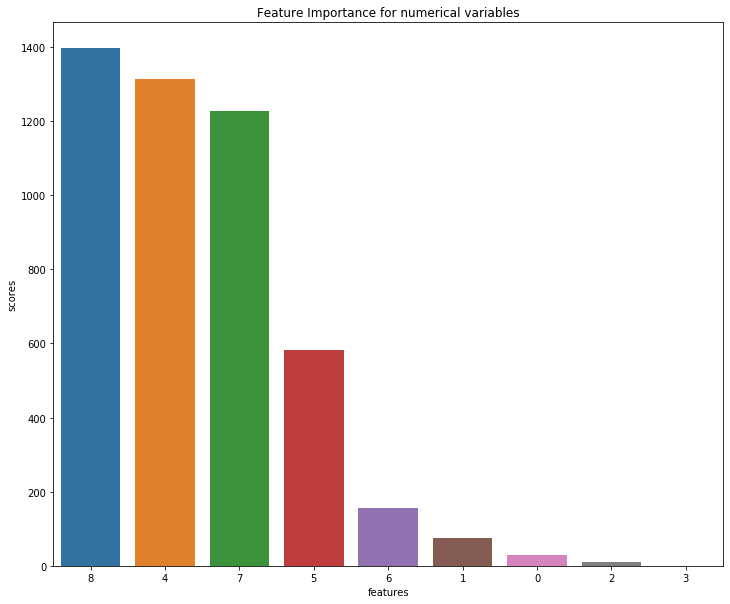

In [171]:
plt.subplots(figsize=(12,10))
sns.barplot(data=num_kbest, x='features', y='scores', order=num_kbest.features)
plt.title('Feature Importance for numerical variables')
plt.show()

> I would go with features that equals or above the average score

In [172]:
num_kbest_avg = num_kbest.scores.mean()
num_kbest_avg

532.6002751214006

In [173]:
num_kbest=num_kbest.query('scores >= @num_kbest_avg')
num_kbest

,features,scores
0,8,1397.298094
1,4,1312.651487
2,7,1228.455657
3,5,583.512400


> We have only 4 of such features

> about four features are most useful for our prediction, hence I will go for 4

In [175]:
# define feature selection, 
fs = SelectKBest(score_func=f_classif, k=4)
# apply feature selection
num_selected_kbest = fs.fit_transform(features_num, target)
print(num_selected_kbest.shape)

(37069, 4)


/home/patrick/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [176]:
num_selected_kbest

array([[ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       [ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       [ 1.1000e+00,  9.3994e+01,  4.8570e+00,  5.1910e+03],
       ...,
       [-1.1000e+00,  9.4199e+01,  8.7900e-01,  4.9636e+03],
       [-1.1000e+00,  9.4199e+01,  8.7900e-01,  4.9636e+03],
       [-1.1000e+00,  9.4199e+01,  8.8000e-01,  4.9636e+03]])

> 

#### Perform feature selection on categorical features

> I would take the same approach as the numerical vars on the cat vars

> But first, we have to encode our categorical variables using OneHotEncoding

In [130]:
fs_1 = SelectKBest(score_func=chi2, k='all')
fs_1.fit(features_cat_encode, target)

SelectKBest(k='all', score_func=<function chi2 at 0x7f4b7172cd08>)

In [144]:
for i in range(len(fs_1.scores_)):
	print('Feature %d: %f' % (i, fs_1.scores_[i]))

Feature 0: 19.192975
Feature 1: 34.827808
Feature 2: 0.018024
Feature 3: 7.261408
Feature 4: 0.083253
Feature 5: 18.868787
Feature 6: 1.304342
Feature 7: 8.612814
Feature 8: 123.288332
Feature 9: 0.659547
Feature 10: 0.955333
Feature 11: 0.378734
Feature 12: 4.252584
Feature 13: 18.278362
Feature 14: 58.276237
Feature 15: 0.718807
Feature 16: 21.536106
Feature 17: 5.026870
Feature 18: 12.689765
Feature 19: 0.075758
Feature 20: 0.673479
Feature 21: 1.251001
Feature 22: 53.961137
Feature 23: 0.017317
Feature 24: 32.217282
Feature 25: 110.170986
Feature 26: 0.249861
Feature 27: 0.781847
Feature 28: 2.640205
Feature 29: 1.381006
Feature 30: 0.185618
Feature 31: 2.640205
Feature 32: 0.124968
Feature 33: 137.652102
Feature 34: 216.844617
Feature 35: 316.272892
Feature 36: 5.248167
Feature 37: 85.660468
Feature 38: 5.860430
Feature 39: 4.459332
Feature 40: 701.230763
Feature 41: 86.622513
Feature 42: 22.644214
Feature 43: 285.549469
Feature 44: 67.422005
Feature 45: 0.937036
Feature 46: 3.076

In [152]:
cat_kbest = pd.DataFrame(fs_1.scores_, columns=['scores']).sort_values(
    ascending=False, by='scores').reset_index().rename(columns={'index':'features'})
cat_kbest.head(10)

,features,scores
0,40,701.230763
1,35,316.272892
2,43,285.549469
3,34,216.844617
4,33,137.652102
5,8,123.288332
6,25,110.170986
7,41,86.622513
8,37,85.660468
9,44,67.422005


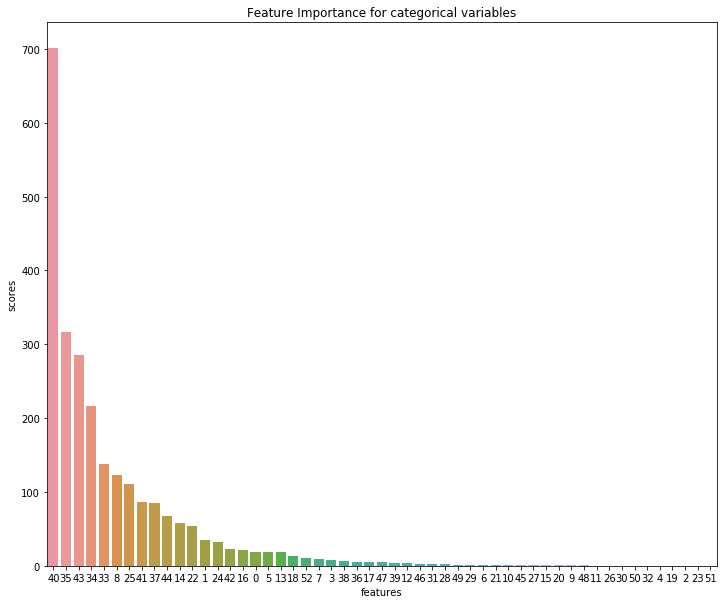

In [158]:
plt.subplots(figsize=(12,10))
sns.barplot(data=cat_kbest, x='features', y='scores', order=cat_kbest.features)
plt.title('Feature Importance for categorical variables')
plt.show()

> I would go with features that equals or above the average score

In [160]:
cat_kbest_avg = cat_kbest.scores.mean()
cat_kbest_avg

47.15224161403169

In [164]:
cat_kbest=cat_kbest.query('scores >= @cat_kbest_avg')
cat_kbest

,features,scores
0,40,701.230763
1,35,316.272892
2,43,285.549469
3,34,216.844617
4,33,137.652102
5,8,123.288332
6,25,110.170986
7,41,86.622513
8,37,85.660468
9,44,67.422005


> We have only 12 of such features

In [ ]:
> I would concatenate 

> encode categorical variables in features

> merge with train data

In [ ]:
for col in to